# Cohort Selection Using MIDRC Temporal COVID Test Data
---
by Chris Meyer, PhD

Manager of Data and User Services at the Center for Translational Data Science at the University of Chicago

August 2022

---
This Jupyter notebook tutorial demonstrates how to use the MIDRC data commons' APIs to access imaging study and COVID-19 test data, how to use temporal properties in those data to select a cohort of COVID-19 positive imaging studies, and how to access those image files.

# Install some Python packages:

In [6]:
## May need to install these Python packages. 
## We should add them to the base workspace image so this is unnecessary..

# !pip install --upgrade --ignore-installed PyYAML
# !pip install --upgrade pip
# !pip install --upgrade gen3
# !pip install cdiserrors
# !pip install pydicom
# !conda install gdcm -c conda-forge -y
# !pip install pylibjpeg

  Using cached gdcm-1.1-py3-none-manylinux1_x86_64.whl (2.7 MB)


# Import Python Packages and scripts

In [11]:
# Import Python Packages and scripts
import pandas as pd
import sys, os, webbrowser
import gen3
import pydicom
import matplotlib.pyplot as plt
import pylibjpeg
#import gdcm

from gen3.submission import Gen3Submission
from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query


In [6]:
# Import some custom Python scripts from personal GitHub repo
home_dir = "/home/jovyan/pd"
gen3_dir = "{}/gen3".format(home_dir)
demo_dir = "{}/demos/Find_COVID_Positive_Imaging_Studies".format(home_dir)
os.system('mkdir -p {}'.format(gen3_dir))

os.system("wget https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py -O /home/jovyan/pd/gen3/expansion.py")
%run /home/jovyan/pd/gen3/expansion.py

os.chdir(demo_dir)


In [7]:
# # Initiate instances of the Gen3 SDK Classes using credentials file uploaded. This is unnecessary with functioning WTS
# api = 'https://data.midrc.org'
# cred = '/home/jovyan/pd/gen3/midrc-credentials.json'
# auth = Gen3Auth(api, refresh_file=cred) # authentication class
# sub = Gen3Submission(api, auth) # submission class
# query = Gen3Query(auth) # query class
# exp = Gen3Expansion(api,auth,sub) # class with some custom scripts
# exp.get_project_ids()

In [8]:
## Initiate instances of the Gen3 SDK Classes using the WTS (no need for uploading credentials.json)

api = 'https://data.midrc.org'
auth = Gen3Auth(api) # authentication class
sub = Gen3Submission(api, auth) # submission class
query = Gen3Query(auth) # query class
exp = Gen3Expansion(api,auth,sub) # class with some custom scripts
exp.get_project_ids()

[2022-05-13 16:03:15,148][WARNING] Unable to find refresh_file
Getting all project_ids you have access to in the data commons.
['NCU-A2', 'NCU-R2', 'Open-A1', 'Open-A1_PETAL_BLUECORAL', 'Open-A1_PETAL_FIRECORAL', 'Open-A1_PETAL_REDCORAL', 'Open-R1', 'TCIA-COVID-19-AR', 'TCIA-COVID-19-NY-SBU', 'TCIA-COVID-19_CT_Images', 'TCIA-RICORD-1a', 'TCIA-RICORD-1b', 'TCIA-RICORD-1c']


['NCU-A2',
 'NCU-R2',
 'Open-A1',
 'Open-A1_PETAL_BLUECORAL',
 'Open-A1_PETAL_FIRECORAL',
 'Open-A1_PETAL_REDCORAL',
 'Open-R1',
 'TCIA-COVID-19-AR',
 'TCIA-COVID-19-NY-SBU',
 'TCIA-COVID-19_CT_Images',
 'TCIA-RICORD-1a',
 'TCIA-RICORD-1b',
 'TCIA-RICORD-1c']


## 1. Will the date of the imaging exam and the date of the COVID test be provided in the metadata?
---

Specific dates are not allowed, but given a single "index_event" for a case, "days to X from index event" properties are provided.

For example, one can query or export the imaging_study node, which has "days_to_study", and the measurement node, which has "test_days_from_index", and merge into a single table on "case_ids" to create a temporal timeline of imaging studies and COVID-19 tests for a cohort of patients.


## Export metadata using submission API
---
Here we'll utilize the MIDRC submission API to export all the imaging study and measurement (COVID-19 tests) data using the ["get_node_tsvs" function](https://github.com/cgmeyer/gen3sdk-python/blob/2aecc6575b22f9cca279b650914971dd6723a2ce/expansion/expansion.py#L219), which is a wrapper to export and merge all the records in a node across each project in the data commons using the [Gen3SDK](https://github.com/uc-cdis/gen3sdk-python/) function [Gen3Submission.export_node()](https://github.com/uc-cdis/gen3sdk-python/blob/5d7b5270ff11cf7037f211cf01e410d8e73d6b84/gen3/submission.py#L361).

In [9]:
# Export all the records in the imaging_study node
st = exp.get_node_tsvs(node='imaging_study')

File previously downloaded.
node_tsvs/imaging_study_tsvs/TCIA-RICORD-1c_imaging_study.tsv has 998 records.
File previously downloaded.
node_tsvs/imaging_study_tsvs/TCIA-COVID-19-NY-SBU_imaging_study.tsv has 7363 records.
File previously downloaded.
node_tsvs/imaging_study_tsvs/TCIA-COVID-19_CT_Images_imaging_study.tsv has 650 records.
File previously downloaded.
node_tsvs/imaging_study_tsvs/Open-A1_imaging_study.tsv has 14528 records.

Output written to file: node_tsvs/imaging_study_tsvs/NCU-A2_imaging_study.tsv
node_tsvs/imaging_study_tsvs/NCU-A2_imaging_study.tsv has 0 records.
Removing empty file: node_tsvs/imaging_study_tsvs/NCU-A2_imaging_study.tsv

Output written to file: node_tsvs/imaging_study_tsvs/NCU-R2_imaging_study.tsv
node_tsvs/imaging_study_tsvs/NCU-R2_imaging_study.tsv has 0 records.
Removing empty file: node_tsvs/imaging_study_tsvs/NCU-R2_imaging_study.tsv
File previously downloaded.
node_tsvs/imaging_study_tsvs/Open-A1_PETAL_REDCORAL_imaging_study.tsv has 3169 records.

In [10]:
# Filter the imaging_study data for only studies that have a non-null "days_to_study" and "DX" study_modality
s = st.loc[(~st['days_to_study'].isna()) & (st['study_modality']=='DX')]
s

,type,id,project_id,submitter_id,age_at_imaging,body_part_examined,case_ids,days_to_study,series_count,study_description,study_location,study_modality,study_uid,study_year,study_year_shifted,cases.id,cases.submitter_id
9011,imaging_study,00043f69-d5a6-479f-9309-71c253b6c09b,Open-A1,2.16.840.1.114274.1818.53927660811344067041430...,NaN,NaN,10000364-1375261,-339.0,NaN,XR CHEST PA AND LATERAL,NaN,DX,2.16.840.1.114274.1818.53927660811344067041430...,NaN,True,420af82e-4a6f-4a4e-8f82-051a3adfc901,10000364-1375261
9012,imaging_study,00066b23-4297-460a-a7e1-2e483fd27a47,Open-A1,10000364-1519515_2.16.840.1.114274.1818.572394...,NaN,NaN,10000364-1519515,-1.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.57239462775962082858120...,NaN,True,c6e03e4a-e0ce-4103-8c00-81fd06d555e2,10000364-1519515
9031,imaging_study,005618eb-8df1-40de-ba6a-a27184c62f34,Open-A1,10000364-1607825_2.16.840.1.114274.1818.550767...,NaN,NaN,10000364-1607825,-40.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.55076773370404755863752...,NaN,True,35f564eb-c9b4-4870-a1fb-626a8f79b3d6,10000364-1607825
9039,imaging_study,0092e28f-5d61-4760-9b75-937e16a04d78,Open-A1,10000364-1465830_2.16.840.1.114274.1818.567734...,NaN,NaN,10000364-1465830,35.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.56773440092156751147307...,NaN,True,df555ac4-3f1a-4272-a240-6f4d7cc296a7,10000364-1465830
9042,imaging_study,009adbf3-abf5-40e4-9f3a-4074076cfca8,Open-A1,10000364-1418152_2.16.840.1.114274.1818.486873...,NaN,NaN,10000364-1418152,-324.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.48687302357140701881833...,NaN,True,ad573d81-2ff2-42db-91c9-ccda6f1626f2,10000364-1418152
9043,imaging_study,009ca121-c289-4249-ab5b-94fc7530f2e7,Open-A1,10000364-1070656_2.16.840.1.114274.1818.548398...,NaN,NaN,10000364-1070656,45.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.54839864627065410741641...,NaN,True,3036d286-a022-4008-8c7e-b7440c95def3,10000364-1070656
9067,imaging_study,00f57c3b-d7c5-4e53-8e0e-d02f9cea8206,Open-A1,10000364-5636388_2.16.840.1.114274.1818.544657...,NaN,NaN,10000364-5636388,124.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.54465758664852955678989...,NaN,True,f212791d-300a-42ba-afb0-8b3e73dc5c04,10000364-5636388
9070,imaging_study,0104b55a-6288-4754-8a37-494df95a95ad,Open-A1,2.16.840.1.114274.1818.51607810898232549052164...,NaN,NaN,10000364-2470802,-114.0,NaN,XR CHEST PA AND LATERAL,NaN,DX,2.16.840.1.114274.1818.51607810898232549052164...,NaN,True,e313882b-bed5-4ba2-9d40-5c6491538332,10000364-2470802
9072,imaging_study,010f004b-38b7-4b29-a6ce-a738f0a34d0e,Open-A1,2.16.840.1.114274.1818.47645127050117245123626...,NaN,NaN,10000364-6604535,-21.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.47645127050117245123626...,NaN,True,8abfd896-5fb1-4c6a-a44c-fa7d8a5586b8,10000364-6604535
9073,imaging_study,01104022-2f5a-447a-a969-6617f396c5b7,Open-A1,10000364-989371_2.16.840.1.114274.1818.5058681...,NaN,NaN,10000364-989371,5.0,NaN,NaN,NaN,DX,2.16.840.1.114274.1818.50586810227525701468386...,NaN,True,fa5c0caf-6cb5-43a1-aedb-739b90ae759a,10000364-989371


In [11]:
# Now export all the data in the measurement node, which is used to store the COVID test data
meas = exp.get_node_tsvs(node='measurement')
meas.head()


Output written to file: node_tsvs/measurement_tsvs/NCU-A2_measurement.tsv
node_tsvs/measurement_tsvs/NCU-A2_measurement.tsv has 0 records.
Removing empty file: node_tsvs/measurement_tsvs/NCU-A2_measurement.tsv

Output written to file: node_tsvs/measurement_tsvs/TCIA-COVID-19-AR_measurement.tsv
node_tsvs/measurement_tsvs/TCIA-COVID-19-AR_measurement.tsv has 0 records.
Removing empty file: node_tsvs/measurement_tsvs/TCIA-COVID-19-AR_measurement.tsv

Output written to file: node_tsvs/measurement_tsvs/Open-A1_PETAL_REDCORAL_measurement.tsv
node_tsvs/measurement_tsvs/Open-A1_PETAL_REDCORAL_measurement.tsv has 0 records.
Removing empty file: node_tsvs/measurement_tsvs/Open-A1_PETAL_REDCORAL_measurement.tsv

Output written to file: node_tsvs/measurement_tsvs/TCIA-RICORD-1c_measurement.tsv
node_tsvs/measurement_tsvs/TCIA-RICORD-1c_measurement.tsv has 0 records.
Removing empty file: node_tsvs/measurement_tsvs/TCIA-RICORD-1c_measurement.tsv

Output written to file: node_tsvs/measurement_tsvs/TC

,type,id,project_id,submitter_id,case_ids,test_days_from_index,test_method,test_name,test_result_text,cases.id,cases.submitter_id,conditions.id,conditions.submitter_id,procedures.id,procedures.submitter_id
0,measurement,000f0255-3060-4725-8438-6bd8cf361454,Open-A1,3685262,10000364-1482780,258,RT-PCR,COVID-19,Negative,5fbc12f0-d746-4988-8cee-2e9657d6f3b3,10000364-1482780,NaN,NaN,NaN,NaN
1,measurement,0026f750-8752-4ea2-b0f9-8a39be6ac3fa,Open-A1,828397,10000364-1373511,95,RT-PCR,COVID-19,Negative,615e08a5-b712-4859-a7ba-3f85ba7c149c,10000364-1373511,NaN,NaN,NaN,NaN
2,measurement,00296991-9b0d-4a51-8161-2bca885a8ff3,Open-A1,20041645,10003752-HFzMVp7y60qpWBAtXZcw,89,RT-PCR,COVID-19,Negative,f27e0e17-acb3-457b-8813-5b9014635693,10003752-HFzMVp7y60qpWBAtXZcw,NaN,NaN,NaN,NaN
3,measurement,0029b125-a25a-40a1-a2dc-7fb3350aea09,Open-A1,4903183,10000364-5526101,53,RT-PCR,COVID-19,Negative,866ef74a-dadb-4b30-b8c1-619acc13c4d2,10000364-5526101,NaN,NaN,NaN,NaN
4,measurement,003e1f6b-73d8-4740-8e8e-0ff014b14df9,Open-A1,19264028,10000364-248952,116,Rapid antigen test,COVID-19,Negative,1c4cb131-00dd-433b-8861-b65bfb533875,10000364-248952,NaN,NaN,NaN,NaN


In [12]:
## Filter the measurements for only COVID-19 tests with a non-null "test_days_from_index" property
m = meas.loc[(~meas['test_days_from_index'].isna()) & (meas['test_name']=='COVID-19')]
m

,type,id,project_id,submitter_id,case_ids,test_days_from_index,test_method,test_name,test_result_text,cases.id,cases.submitter_id,conditions.id,conditions.submitter_id,procedures.id,procedures.submitter_id
0,measurement,000f0255-3060-4725-8438-6bd8cf361454,Open-A1,3685262,10000364-1482780,258,RT-PCR,COVID-19,Negative,5fbc12f0-d746-4988-8cee-2e9657d6f3b3,10000364-1482780,NaN,NaN,NaN,NaN
1,measurement,0026f750-8752-4ea2-b0f9-8a39be6ac3fa,Open-A1,828397,10000364-1373511,95,RT-PCR,COVID-19,Negative,615e08a5-b712-4859-a7ba-3f85ba7c149c,10000364-1373511,NaN,NaN,NaN,NaN
2,measurement,00296991-9b0d-4a51-8161-2bca885a8ff3,Open-A1,20041645,10003752-HFzMVp7y60qpWBAtXZcw,89,RT-PCR,COVID-19,Negative,f27e0e17-acb3-457b-8813-5b9014635693,10003752-HFzMVp7y60qpWBAtXZcw,NaN,NaN,NaN,NaN
3,measurement,0029b125-a25a-40a1-a2dc-7fb3350aea09,Open-A1,4903183,10000364-5526101,53,RT-PCR,COVID-19,Negative,866ef74a-dadb-4b30-b8c1-619acc13c4d2,10000364-5526101,NaN,NaN,NaN,NaN
4,measurement,003e1f6b-73d8-4740-8e8e-0ff014b14df9,Open-A1,19264028,10000364-248952,116,Rapid antigen test,COVID-19,Negative,1c4cb131-00dd-433b-8861-b65bfb533875,10000364-248952,NaN,NaN,NaN,NaN
5,measurement,004a9577-1d95-43c7-8434-a75bf7e2c39f,Open-A1,2835337,10000364-1432680,154,Rapid antigen test,COVID-19,Negative,b28265eb-46c0-408b-a5af-3dcc26ce843b,10000364-1432680,NaN,NaN,NaN,NaN
6,measurement,004c97dc-9d9c-4d3f-922b-4ede8cc3301b,Open-A1,3414070,10000364-6597094,18,RT-PCR,COVID-19,Negative,acf5ee90-89e2-4352-9043-893d1d4c3b22,10000364-6597094,NaN,NaN,NaN,NaN
7,measurement,00507d2f-b03d-4b4c-9d38-8a5b4f16e241,Open-A1,20034544,10008204-iLz3dR5ZX0a3B8rV9bojw,0,RT-PCR,COVID-19,Negative,524f9bc6-1ac8-4b6b-988f-3ed7ebc5400b,10008204-iLz3dR5ZX0a3B8rV9bojw,NaN,NaN,NaN,NaN
8,measurement,005214a2-40e4-420c-996a-b90bcba2450d,Open-A1,2474933,10000364-2080371,1,RT-PCR,COVID-19,Negative,533ee767-e790-4604-a83f-eabd8a52b7a2,10000364-2080371,NaN,NaN,NaN,NaN
9,measurement,00542342-5201-4905-865a-61935e747fa5,Open-A1,1367895,10000364-504715,62,RT-PCR,COVID-19,Negative,d5c1b8db-7006-49d2-af98-a00038baa6f1,10000364-504715,NaN,NaN,NaN,NaN


In [13]:
## Check out the properties in each DataFrame to help make a list of properties to merge into a single table
display(list(s))
display(len(s))
display(list(m))
display(len(m))

['type',
 'id',
 'project_id',
 'submitter_id',
 'age_at_imaging',
 'body_part_examined',
 'case_ids',
 'days_to_study',
 'series_count',
 'study_description',
 'study_location',
 'study_modality',
 'study_uid',
 'study_year',
 'study_year_shifted',
 'cases.id',
 'cases.submitter_id']

4755

['type',
 'id',
 'project_id',
 'submitter_id',
 'case_ids',
 'test_days_from_index',
 'test_method',
 'test_name',
 'test_result_text',
 'cases.id',
 'cases.submitter_id',
 'conditions.id',
 'conditions.submitter_id',
 'procedures.id',
 'procedures.submitter_id']

11282

In [14]:
## Merge the imaging_study and measurement data using "case_ids" as a foreign key
temp = pd.merge(s[['study_uid','days_to_study','case_ids']],meas[['project_id','submitter_id','test_name','test_result_text','case_ids','test_days_from_index']],on='case_ids')
display(temp)

,study_uid,days_to_study,case_ids,project_id,submitter_id,test_name,test_result_text,test_days_from_index
0,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1757168,COVID-19,Positive,303
1,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1970385,COVID-19,Negative,490
2,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1852379,COVID-19,Positive,303
3,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1757167,COVID-19,Negative,460
4,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1749586,COVID-19,Negative,47
5,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1913938,COVID-19,Positive,101
6,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1689955,COVID-19,Negative,0
7,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1691260,COVID-19,Positive,56
8,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1916704,COVID-19,Positive,79
9,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1791797,COVID-19,Positive,49


## Calculate the days from COVID-19 test to an imaging_study
---
Now that we have the temporal data for imaging studies and COVID-19 tests in a single DataFrame for all cases in MIDRC for which this data is provided, we can calculate the number of days between each COVID-19 test and each imaging study, which we'll call `days_from_test_to_study`.

* Note: In MIDRC, a negative "days to XYZ" indicates that the event XYZ took place that many days prior to the index event, while a positive "days to" indicates the number of days since the index event. For example, a "days_to_study" of "-10" indicates that the imaging study was performed 10 days *before* the index event. A value of "365" indicates the imaging study took place one year *after* the index event. 

We expect a positive value if the test was performed before the study.
- So, if `test_days_from_index` is `1` and `days_to_study` is `4`, the `days_from_test_to_study` should be `3`, which means the study took place 3 days after the test. 
- If the test is on day 4 and the study is on day 1, then the `days_from_test_to_study` is `-3`, meaning the study took place 3 days before the test.



In [15]:
## Calculate the days from COVID-19 test to an imaging_study
temp['days_from_test_to_study'] = temp['days_to_study'] - temp['test_days_from_index']
display(temp)

,study_uid,days_to_study,case_ids,project_id,submitter_id,test_name,test_result_text,test_days_from_index,days_from_test_to_study
0,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1757168,COVID-19,Positive,303,-642.0
1,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1970385,COVID-19,Negative,490,-829.0
2,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1852379,COVID-19,Positive,303,-642.0
3,2.16.840.1.114274.1818.53927660811344067041430...,-339.0,10000364-1375261,Open-A1,1757167,COVID-19,Negative,460,-799.0
4,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1749586,COVID-19,Negative,47,-48.0
5,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1913938,COVID-19,Positive,101,-102.0
6,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1689955,COVID-19,Negative,0,-1.0
7,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1691260,COVID-19,Positive,56,-57.0
8,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1916704,COVID-19,Positive,79,-80.0
9,2.16.840.1.114274.1818.57239462775962082858120...,-1.0,10000364-1519515,Open-A1,1791797,COVID-19,Positive,49,-50.0


## Identify "COVID-19 positive" imaging studies
---
Now that we've calculated `days_from_test_to_study`, we can define a cut-off value and filter the imaging studies using that value to determine which imaging studies were performed within a certain time-frame of receiving a positive COVID-19 test.

Our new property `days_from_test_to_study` has a positive value if the COVID test was performed before the imaging study (i.e., there were +3 days from the test date to the study date) and a negative value if the test was performed after the imaging study (i.e., go back in time 3 days from the test date to the study date). 

For this demo, let's assume that an imaging study was performed when a person was "COVID-positive" if the imaging study was performed within a 10-day range of a positive test result. So, we'll filter the DataFrame of studies for a `days_from_test_to_study` in the range of -5 to 5 and also require the `test_result_text` to be `Positive`.


In [16]:
ps = temp.loc[(temp['days_from_test_to_study'] < 5) & (temp['days_from_test_to_study'] > -5) & (temp['test_result_text']=='Positive')]
display(ps)

,study_uid,days_to_study,case_ids,project_id,submitter_id,test_name,test_result_text,test_days_from_index,days_from_test_to_study
519,2.16.840.1.114274.1818.49730838145991625671237...,0.0,10000364-1441843,Open-A1,19375484,COVID-19,Positive,0,0.0
804,2.16.840.1.114274.1818.54429352050740460131192...,0.0,10000364-6481317,Open-A1,4916547,COVID-19,Positive,1,-1.0
805,2.16.840.1.114274.1818.54429352050740460131192...,0.0,10000364-6481317,Open-A1,4447830,COVID-19,Positive,0,0.0
890,2.16.840.1.114274.1818.48021771159095447451766...,0.0,10000364-1430082,Open-A1,4559135,COVID-19,Positive,4,-4.0
891,2.16.840.1.114274.1818.48021771159095447451766...,0.0,10000364-1430082,Open-A1,4976581,COVID-19,Positive,0,0.0
1287,2.16.840.1.114274.1818.48157555954506242031292...,-2.0,10000364-1629557,Open-A1,4029236,COVID-19,Positive,0,-2.0
1349,2.16.840.1.114274.1818.52277190787710549031199...,231.0,10000364-1841406,Open-A1,5068111,COVID-19,Positive,231,0.0
1373,2.16.840.1.114274.1818.53840514870842921501028...,172.0,10000364-2579994,Open-A1,2610336,COVID-19,Positive,170,2.0
1793,2.16.840.1.114274.1818.53254162557788114198494...,3.0,10000364-5623150,Open-A1,5260278,COVID-19,Positive,0,3.0
1923,2.16.840.1.114274.1818.49623065213006336731706...,-1.0,10000364-582005,Open-A1,3360799,COVID-19,Positive,0,-1.0


In [17]:
os.chdir(demo_dir)
filename = 'DX_imaging_studies_plus_covid_tests.tsv' 
ps.to_csv(filename,sep='\t',index=False)

In [18]:
ll

total 360
-rw-rw-r-- 1 jovyan   7076 May 13 15:32 covid_positive_DX_imaging_studies_10d_window_with_object_ids.tsv
-rw-rw-r-- 1 jovyan   6614 May 13 16:03 DX_imaging_studies_plus_covid_tests.tsv
-rw-rw-r-- 1 jovyan   5418 May 13 15:50 MIDRC_DX_imaging_studies_covid_positive_manifest.json
drwxrwsr-x 4 jovyan   4096 May 12 22:55 node_tsvs/
-rw-rw-r-- 1 jovyan 339581 May 13 16:01 Xray_Temporal_Data_and_Files.ipynb


## Get the imaging files for the identified studies or cases.
---
Now that we have a list of imaging studies that were deemed to take place when a patient was infected with COVID-19, we can use the study_uid, which is a unique identifier for imaging studies, to collect the associated files. If we want *all* the imaging studies for the cohort of identified cases, e.g., to have a "healthy" or "baseline" images for comparison, we can instead use the case_ids to pull all imaging files for the cases, keeping in mind that this will pull any additional imaging studies that may fall outside our defined temporal range.

In [19]:
## Make a list of study_uids and case_ids

## read in previously saved DataFrame if restarting notebook:
# pd.read_csv(filename, sep='\t', dtype=str)

cids = list(set(ps['case_ids']))
display(len(cids))

sids = list(set(ps['study_uid']))
display(len(sids))

44

46

In [20]:
## This query retrieves ALL imaging_study records, we will next filter these results based on the COVID test data
res = query.query(
                data_type="imaging_study",
                first=30000,
                fields=[
                    "study_uid",
                    "case_ids",
                    "object_id",
                    "project_id"
                    #"file_name"
                ]
)


In [21]:
## Take a glance at the returned data
st = res['data']['imaging_study']
display(len(st))
st[1:2]


29630

[{'case_ids': ['A342018'],
  'study_uid': '1.3.6.1.4.1.14519.5.2.1.99.1071.27284350109903016803354882740889',
  'project_id': 'TCIA-COVID-19-NY-SBU',
  'object_id': ['dg.MD1R/ddc683ce-621c-4b64-a146-253c0d1f9ca7',
   'dg.MD1R/7d309ba2-0692-4b7e-9a55-b99e28f249f0']}]

In [22]:
# convert the query data to a DataFrame and remove any records that lack a study_uid or object_id
oids = pd.DataFrame(st)
oids = oids.loc[(~oids['object_id'].isna())&(~oids['study_uid'].isna())]
len(oids)

18415

In [23]:
# convert lists to strings; necessary because the properties case_ids and object_id are arrays in the dictionary, and thus are returned as lists.

oids['case_ids'] = [','.join(map(str, l)) for l in oids['case_ids']]
#oids['object_id'] = [','.join(map(str, l)) for l in oids['object_id']]

In [24]:
# Now filter the imaging studies based on our temporal results
toids = oids.loc[oids['study_uid'].isin(sids)]
len(toids)

33

In [25]:
display(toids)

,case_ids,object_id,project_id,study_uid
850,10000364-6563400,"[dg.MD1R/ee949e99-6d03-4a4c-a32c-d40ab29e2fc5,...",Open-A1,2.16.840.1.114274.1818.49938722868158878271423...
1360,10000364-1583101,"[dg.MD1R/1ce5b6e0-c53f-4006-8da2-cd385615cb55,...",Open-A1,2.16.840.1.114274.1818.52779345069819425519366...
1782,10000364-1529476,"[dg.MD1R/5746000a-b513-442f-a2f4-05acbe847f0a,...",Open-A1,2.16.840.1.114274.1818.57465404281606135501004...
2134,10000364-900710,"[dg.MD1R/0d4b7b2f-874a-4b27-bdb7-a52871a8ec30,...",Open-A1,2.16.840.1.114274.1818.49737935697536517401293...
3533,10000364-1509832,"[dg.MD1R/7f181e8c-cce1-47a3-8b4b-84028df7887b,...",Open-A1,2.16.840.1.114274.1818.55556814984927382924042...
4545,10000364-1626259,"[dg.MD1R/4b84fd74-0615-4129-b281-35a3f1ccfdc6,...",Open-A1,2.16.840.1.114274.1818.49960126038261448015780...
7303,10000364-1563819,"[dg.MD1R/fe45a299-f1fc-4f1a-b66c-7c5f86f2d964,...",Open-A1,2.16.840.1.114274.1818.53256507062586789144869...
8921,10000364-1451946,"[dg.MD1R/d7ec9e11-b688-4a7b-9821-d6f653aede8c,...",Open-A1,2.16.840.1.114274.1818.52672479988862611843187...
9822,10000364-1532266,"[dg.MD1R/5226b41f-6b8e-4f39-be19-6196d3914576,...",Open-A1,2.16.840.1.114274.1818.47992548380110931489204...
10347,10000364-1712991,"[dg.MD1R/6a3fe453-c8f0-4525-9a93-178ba1a82cfe,...",Open-A1,2.16.840.1.114274.1818.46728737024781783052904...


In [26]:
# save our result to a DataFrame
results_name = "covid_positive_DX_imaging_studies_10d_window_with_object_ids.tsv"
toids.to_csv(results_name,sep='\t',index=False)



In [27]:
!ls -l

total 360
-rw-rw-r-- 1 jovyan users   7076 May 13 16:03 covid_positive_DX_imaging_studies_10d_window_with_object_ids.tsv
-rw-rw-r-- 1 jovyan users   6614 May 13 16:03 DX_imaging_studies_plus_covid_tests.tsv
-rw-rw-r-- 1 jovyan users   5418 May 13 15:50 MIDRC_DX_imaging_studies_covid_positive_manifest.json
drwxrwsr-x 4 jovyan users   4096 May 12 22:55 node_tsvs
-rw-rw-r-- 1 jovyan users 339581 May 13 16:01 Xray_Temporal_Data_and_Files.ipynb


In [28]:
object_ids = list(set([a for b in toids.object_id.tolist() for a in b]))

In [29]:
len(object_ids)

86

In [30]:
manifest = [{"object_id":i} for i in object_ids]
display(len(manifest))
display(manifest)

86

[{'object_id': 'dg.MD1R/5226b41f-6b8e-4f39-be19-6196d3914576'},
 {'object_id': 'dg.MD1R/6e65395a-0d7a-4bd7-b460-7e1e99b08604'},
 {'object_id': 'dg.MD1R/be359171-4610-462d-b865-35c2b51db60c'},
 {'object_id': 'dg.MD1R/7c34fa51-8e61-464d-9793-aa1d52a8977d'},
 {'object_id': 'dg.MD1R/0751e5bb-0ea2-4482-9489-1b28804daa87'},
 {'object_id': 'dg.MD1R/152191a0-0129-4983-9953-05da92f539de'},
 {'object_id': 'dg.MD1R/e21088c2-f006-446e-b43e-f680eddaca83'},
 {'object_id': 'dg.MD1R/df7ab633-ae31-4331-b02b-8c5626ea0124'},
 {'object_id': 'dg.MD1R/a26284d9-ff4d-4f76-9682-5c56e847476e'},
 {'object_id': 'dg.MD1R/00c4ac70-06f3-4a92-8168-9f9eb5027dc2'},
 {'object_id': 'dg.MD1R/6f438425-960c-4c04-b57a-6ea0c2c098e7'},
 {'object_id': 'dg.MD1R/47fc27cb-9263-4187-9145-158cbce373e9'},
 {'object_id': 'dg.MD1R/0100b0bb-7242-4903-b96a-5d6d54a8136b'},
 {'object_id': 'dg.MD1R/ee949e99-6d03-4a4c-a32c-d40ab29e2fc5'},
 {'object_id': 'dg.MD1R/c8a897d8-6bd0-4594-93f5-a1114bf67f1e'},
 {'object_id': 'dg.MD1R/1dcc13db-23d5-40

In [31]:
mani_name = 'MIDRC_DX_imaging_studies_covid_positive_manifest.json'
with open(mani_name,'w') as mani: 
      mani.write(str(manifest))

In [32]:
ll

total 360
-rw-rw-r-- 1 jovyan   7076 May 13 16:03 covid_positive_DX_imaging_studies_10d_window_with_object_ids.tsv
-rw-rw-r-- 1 jovyan   6614 May 13 16:03 DX_imaging_studies_plus_covid_tests.tsv
-rw-rw-r-- 1 jovyan   5418 May 13 16:03 MIDRC_DX_imaging_studies_covid_positive_manifest.json
drwxrwsr-x 4 jovyan   4096 May 12 22:55 node_tsvs/
-rw-rw-r-- 1 jovyan 339581 May 13 16:01 Xray_Temporal_Data_and_Files.ipynb


In [98]:
object_id = object_ids[3]
object_id

'dg.MD1R/7c34fa51-8e61-464d-9793-aa1d52a8977d'

In [99]:
!gen3 drs-pull object dg.MD1R/7c34fa51-8e61-464d-9793-aa1d52a8977d


[2022-05-13 16:39:29,570][WARNING] Unable to find refresh_file


In [101]:
#ll 2.16.840.1.114274.1818.5347323039417253111366886901564145793
!ls -l 2.16.840.1.114274.1818.52513335950400868962638133225506790845

total 3600
-rw-r--r-- 1 jovyan users 3682944 May 13 16:39 2.16.840.1.114274.1818.493290470347749632917396619355176140189.dcm


In [14]:
#study_uid = "2.16.840.1.114274.1818.5347323039417253111366886901564145793"
study_uid = "2.16.840.1.114274.1818.52513335950400868962638133225506790845"

In [15]:
#dfile = "{}/2.16.840.1.114274.1818.522083088410440752714944649785971821491.dcm".format(study_uid)
dfile = "{}/2.16.840.1.114274.1818.493290470347749632917396619355176140189.dcm".format(study_uid)
dimg = pydicom.dcmread(dfile,force=True)

In [16]:
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 222
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.114274.1818.493290470347749632917396619355176140189
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.25403.1.1.1
(0002, 0013) Implementation Version Name         SH: 'Dicom 0.1'
(0002, 0016) Source Application Entity Title     AE: 'CPV-ACUOPRIAPP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: ''
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) In

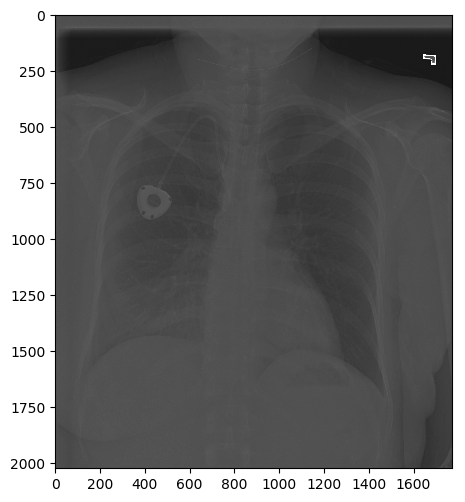

In [17]:
## tell matplotlib to display our images as 6 x 6 inch image, with resolution of 100 dpi
plt.figure(figsize = (6,6), dpi=100) 

## tell matplotlib to display our image, using a gray-scale lookup table.
plt.imshow(dimg.pixel_array, cmap=plt.cm.gray) 